Pix2pix training
================



In [1]:
import os
import sys
from IPython import display # we will use this to clear the results

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/')  # 'My Drive' is the default name of Google Drives
    os.chdir('drive/My Drive/2023-DMLAP/DMLAP/python') # change to your favourite dir

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Datasets

Download a dataset, e.g.:

- [Standard pix2pix datasets](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)
- [Comic faces](https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic)
- [Maps](https://www.kaggle.com/datasets/alincijov/pix2pix-maps)
- [Rembrandt](https://www.kaggle.com/datasets/grafstor/rembrandt-pix2pix-dataset)
- [Depth](https://www.kaggle.com/datasets/greg115/pix2pix-depth)

Or create your own using the notebook.

Beware the sizes! Some of them are pretty big.

## Load and preprocess dataset


Let's first specify the path of our dataset and the desired image size (do not change the latter):


In [3]:
dataset_dir = "datasets/edges2comics" # Change this for your custom dataset

model_dir = "models/edges2comics" # Can change. Model files and resulting images will be saved in this directory
os.makedirs(model_dir, exist_ok=True) # this actually creates the directory if it does not exist

generated_dir = os.path.join(model_dir , "generated") # For our generated pictures
os.makedirs(generated_dir, exist_ok=True)

BUFFER_SIZE = 400 # somewhat arbitrary, could be pushed up if memory allows
BATCH_SIZE = 1
IMG_SIZE = 256
IMG_CHANNELS = 3
IMG_EXTENSION = ".png" # change if jpg instead!

Each training image in a standard pix2pix dataset consists of one imgage divided into two adjacent **source** and **target** images.
The layout of the source and target may vary from training set to trainig set, so we provide a `TARGET_INDEX` flag the determines on which side the target is (`0` if on the left and `1` if on the right). Set this so the examples from the dataset appear with the source image to the left.

The following code also **augments** the dataset by applying random uniform scaling (by upscaling and cropping) and random mirroring to the input output pairs. This should lead to a more stable model according to the original pix2pix paper. Finally the images ar normalized to the [-1,1] range as required by our GAN-based model.

We will organize the dataset in batches of size `1`, as that is generally suggested for pix2pix models. That means that we will update the weights of the model for each image pair separately.

Run the code below and examine the resulting example images. Then set the `TARGET_INDEX` variable to reflect the position of the target image. That is `TARGET_INDEX=0` if the target image is on the left and `TARGET_INDEX=1` if it is on the right.



In [4]:
TARGET_INDEX = 1

def norm(x):
    """Normalize the inputs to [-1, 1] (generator with 'tanh' activation)"""
    return (x - 127.5) / 127.5

def denorm(x):
    """Denormalize the outputs from [-1, 1] to [0,255] (generator with 'tanh' activation)"""
    return (x + 1) * 127.5

def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    target_image = tf.image.resize(
        target_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return input_image, target_image

def random_crop(input_image, target_image):
    stacked_image = tf.stack([input_image, target_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, target_image):
    # Resizing to 286x286
    input_image, target_image = resize(input_image, target_image, 286, 286)
    # Random cropping back to 256x256
    input_image, target_image = random_crop(input_image, target_image)
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
    return input_image, target_image

def load(image_file, target_index=1, img_channels=3):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=img_channels, expand_animations=False) # https://stackoverflow.com/a/59944421

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2

    if target_index == 0:
        input_image = image[:, w:, :]
        target_image = image[:, :w, :]
    else:
        target_image = image[:, w:, :]
        input_image = image[:, :w, :]

    # Convert both images to float32 tensors & normalize
    input_image = norm(tf.cast(input_image, tf.float32))
    target_image = norm(tf.cast(target_image, tf.float32))

    return input_image, target_image

def load_and_preprocess(image_file):
    input_image, target_image = load(image_file, target_index=TARGET_INDEX)
    input_image, target_image = random_jitter(input_image, target_image)
    return input_image, target_image

dataset = tf.data.Dataset.list_files(os.path.join(dataset_dir, f"*{IMG_EXTENSION}"))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

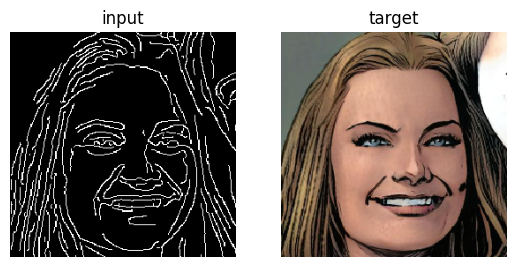

In [6]:
for input_img, output_img in dataset.take(1):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("input")
    plt.imshow(denorm(input_img.numpy()).astype("int32")[0])
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("target")
    plt.imshow(denorm(output_img.numpy()).astype("int32")[0])
    plt.axis("off")
    plt.show()

## Build  the model



The pix2pix model is a conditional generative adversarial network (cGAN). A CGAN
is a type of GAN model used for generating new data samples with specific
attributes or characteristics. In a CGAN, both the generator and discriminator
are *conditioned* on additional information, such as class labels, tags, or
other types of metadata. The generator network takes in random noise as well as
the conditional information as input and produces a new data sample that matches
the desired attributes. The discriminator network, on the other hand, tries to
distinguish between the generated samples and real samples based on both their
visual appearance and the conditional information. For the case of a pix2pix
model the network is conditioned on an image, which should be transformed into
an output image.



### Generator



Differently from a DC-GAN, the generator of the pix2pix model is based on the
[U-net](https://arxiv.org/abs/1505.04597) architecture. A U-net model is a CNN architecture that is typically used
for image segmentation tasks. The name U-net derives from the architecture,
which resembles the letter &ldquo;U&rdquo;. It consists of two main parts: an *encoder* and
a *decoder*. The encoder part consists of a series of convolutional layers,
which reduce the spatial dimensionality of the input image while increasing its
depth. This is followed by a bottleneck layer that extracts the most important
features from the input image. The decoder part is a &ldquo;mirror image&rdquo; of the
encoder. It consists of a series of layers that gradually increase the spatial
dimensionality of the output, while decreasing its depth. This is similar to
what we have seen in the DC-GAN example, but here we use a &ldquo;transposed
convolution&rdquo; layer (`Conv2DTranspose`), while in the DCGAN example we used an
upscaling followed by a convolution. The output of each layer in the encoder is
also concatenated with the output of another layer in the decoder. This creates
&ldquo;skip connections&rdquo; that help preserve spatial information and avoid information
loss during the encoding and decoding process.



In [7]:
def downsample(filters, size, apply_batchnorm=True):
    init = tf.random_normal_initializer(0.0, 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=init,
            use_bias=False,
        )
    )
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0.0, 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=init,
            use_bias=False,
        )
    )
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result


def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (BATCH_SIZE, 128, 128, 64)
        downsample(128, 4),                       # (BATCH_SIZE, 64, 64, 128)
        downsample(256, 4),                       # (BATCH_SIZE, 32, 32, 256)
        downsample(512, 4),                       # (BATCH_SIZE, 16, 16, 512)
        downsample(512, 4),                       # (BATCH_SIZE, 8, 8, 512)
        downsample(512, 4),                       # (BATCH_SIZE, 4, 4, 512)
        downsample(512, 4),                       # (BATCH_SIZE, 2, 2, 512)
        downsample(512, 4),                       # (BATCH_SIZE, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),     # (BATCH_SIZE, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),     # (BATCH_SIZE, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),     # (BATCH_SIZE, 8, 8, 1024)
        upsample(512, 4),                         # (BATCH_SIZE, 16, 16, 1024)
        upsample(256, 4),                         # (BATCH_SIZE, 32, 32, 512)
        upsample(128, 4),                         # (BATCH_SIZE, 64, 64, 256)
        upsample(64, 4),                          # (BATCH_SIZE, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        IMG_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    )                                             # (BATCH_SIZE, 256, 256, 3)
    x = inputs
    # THE MODEL
    # 1. Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # 2. Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator = build_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

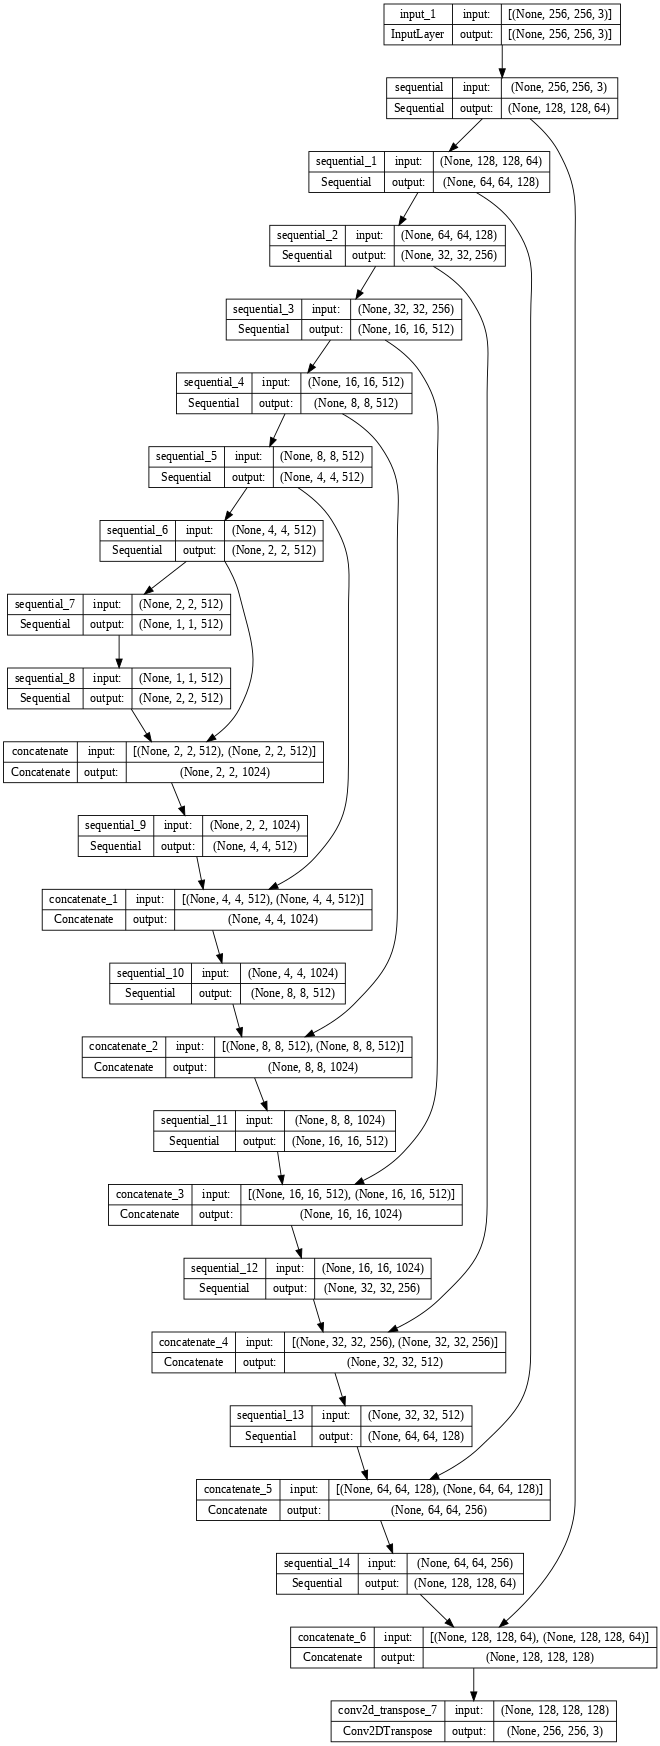

In [16]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.



In [8]:
def build_discriminator():
    init = tf.random_normal_initializer(0.0, 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name="input_image")
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name="target_image")

    x = tf.keras.layers.concatenate([inp, tar])             # (BATCH_SIZE, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)                     # (BATCH_SIZE, 128, 128, 64)
    down2 = downsample(128, 4)(down1)                       # (BATCH_SIZE, 64, 64, 128)
    down3 = downsample(256, 4)(down2)                       # (BATCH_SIZE, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)      # (BATCH_SIZE, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4,
        strides=1,
        kernel_initializer=init,
        use_bias=False
    )(zero_pad1)                                            # (BATCH_SIZE, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (BATCH_SIZE, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4,
        strides=1,
        kernel_initializer=init
    )(zero_pad2)                                            # (BATCH_SIZE, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_15 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate_7[0][0]'] 

### Generate some images before training



Let&rsquo;s generate some images before training to see what the network will output



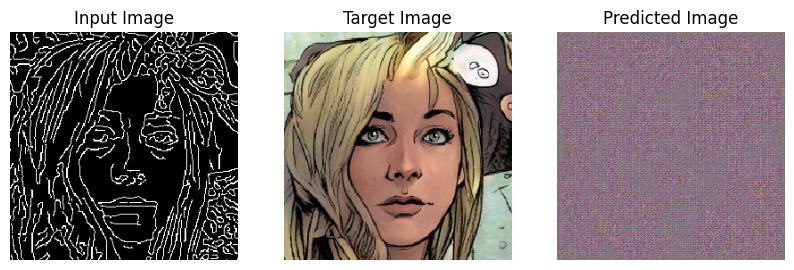

In [9]:
def generate_images(model, test_input, tar, fname=''):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))

    if tar is not None:
        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Target Image', 'Predicted Image']
    else:
        display_list = [test_input[0], prediction[0]]
        title = ['Input Image', 'Predicted Image']

    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 255] range to plot.
        img = tf.cast(denorm(display_list[i]), tf.uint8)
        plt.imshow(img)
        plt.axis('off')

    # IDEA: this only saves the whole figure, instead you could save
    # the target only!
    if fname:
        plt.savefig(fname)

    plt.show()

for example_input, example_target in dataset.take(1):
    generate_images(generator, example_input, example_target)

## Training the model



### Generator loss



GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

-   The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
-   The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
-   This allows the generated image to become structurally similar to the target image.
-   The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

Feel free to experiment with modifying the value of `LAMBDA` (if you have time to spare:))



The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


In [10]:
LAMBDA = 100 # lambda determines how strong we want the MAE to weigh in our full gen loss
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) # mean absolute error
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

### Discriminator loss



The discriminator loss function takes 2 inputs: real images and generated images.

-   The `real_loss` is a sigmoid cross-entropy loss of the real images and an array of ones (since these are the real images).
-   The `generated_loss` is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
-   The `total_loss` is simply the sum of `real_loss` and `generated_loss`.

In [11]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

### Training loop



The training loop procedes as follows:

-   For each example input we generate an output.
-   The discriminator receives the input image and the generated image as the first input. The second input is the input image and the target image.
-   Next, calculate the generator and the discriminator loss.
-   Then, calculate the gradients of the loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.



In [12]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, input_target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, input_target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, input_target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(
            gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(
            zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [13]:
def plot(step, steps, d_losses, g_losses):
    """
    Book-keeping: visualize losses and one example image for the epoch
    """
    display.clear_output(wait=True)
    plt.figure(figsize=(6, 5))
    plt.title(f"Losses | step: {step}/{steps}")
    plt.plot(np.array(d_losses) * 40, label="Discriminator")
    plt.plot(g_losses, label="Generator")
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(model_dir, "losses.png"))

# those will contain our losses
g_losses = []
d_losses = []

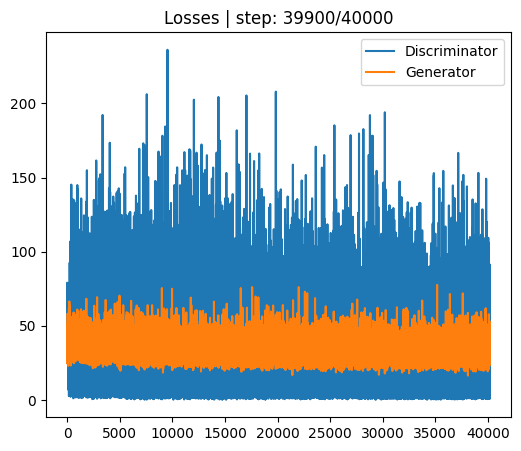

Saving step 39900 to models/edges2comics


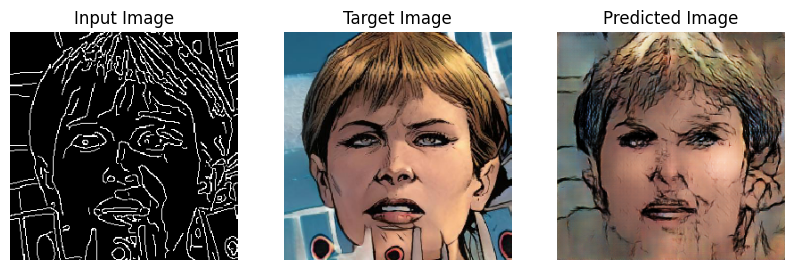

Step 39920/40000 [G total loss: 33.4217 | D loss: 0.5037]
Step 39940/40000 [G total loss: 28.9139 | D loss: 0.5098]
Step 39960/40000 [G total loss: 29.6765 | D loss: 0.6217]
Step 39980/40000 [G total loss: 33.2500 | D loss: 0.3753]


In [15]:
STEPS = 40000
PRINT_EVERY = 20
SAVE_EVERY = 1000
# ↑ try a lower number at first to see the results, e.g. 300, but when you train for a long time
# you don't need to save all these models, and you could consider saving even less often (every
# 10'000? One thing to keep in mind in that regard is that Colab tends to shut down sessions after
# around 3h of inactivity, so make sure to save in an interval that is less than that!)

for step, (input_image, input_target) in dataset.repeat().take(STEPS).enumerate():

    gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, input_target)
    g_l, d_l = gen_total_loss.numpy(), disc_loss.numpy()
    g_losses.append(g_l)
    d_losses.append(d_l)

    if step > 0 and step % (PRINT_EVERY) == 0:
        # display.clear_output(wait=True)
        print(f"Step {step:>{len(str(STEPS))}}/{STEPS} [G total loss: {g_l:.4f} | D loss: {d_l:.4f}]")

    # Save some example images and store model file
    if step > 0 and step % SAVE_EVERY == 0:
        plot(step, STEPS, d_losses, g_losses)
        print(f"Saving step {step} to {model_dir}")
        generate_images(
            generator,
            input_image,  # IDEA: here we use a different input each time, but you could instead import the logic
            input_target, #       from the DCGAN and fix one input_image & input_target outside the loop, to see the evolution!
            fname=os.path.join(generated_dir, f"e{step:03}d_generated_image.png")
        )
        generator.save(os.path.join(model_dir, f"e{step:03}_generator.hd5"), save_format='h5')